In [93]:
import sys
sys.path.append('/home/gperri-ext/master_thesis_tryout/')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, ConvLSTM1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from models.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from models.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from models.windowing_data import multivariate_data, prepare_data
from models.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features

from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


### Importing data

In [3]:
data_folder = "/home/gperri-ext/master_thesis_tryout/data"
file_name = "all_data.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [4]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
# Separate features inputs
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]
df_PUN7 = df.iloc[:,:2]
df_total_load_f = df_total_load.iloc[:,:-1]

### Preparing I/O

In [ ]:
# df.columns
# df_temp = df[['PUN','PUN_d+1-7','GAS','GiornoSettimana', 'Ora', 'holiday']]

In [6]:
# Choose dataset input
dataset_input = make_yearly_dataset(df, 2022, 2023)
print(dataset_input.tail(5))

                              PUN  PUN_d+1-7  PUN_d+1-14    GAS  GAS_d+1-7   
Time_data                                                                    
2023-11-07 19:00:00+00:00  167.02     158.11      142.35  42.15      38.54  \
2023-11-07 20:00:00+00:00  132.16     146.76      130.55  42.15      38.54   
2023-11-07 21:00:00+00:00  127.06     121.55      130.55  42.15      38.54   
2023-11-07 22:00:00+00:00  123.44      85.54      129.70  42.15      38.54   
2023-11-07 23:00:00+00:00  118.79      41.75      129.42  42.15      38.54   

                           Total_load_f  Total_Load_d+1-7  GiornoSettimana   
Time_data                                                                    
2023-11-07 19:00:00+00:00       42197.0          36289.52                1  \
2023-11-07 20:00:00+00:00       40003.0          34429.66                1   
2023-11-07 21:00:00+00:00       37063.0          31412.46                1   
2023-11-07 22:00:00+00:00       33188.0          28461.51      

In [7]:
target_size = 24
past_history = 24
train_size = 0.7
test_size = 0.3

train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

In [8]:
univariate=False

X, y = prepare_data(dataset_input, univariate=univariate)

In [9]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [10]:
step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                        0, train_index, past_history,
                                        target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    train_index, test_index, past_history,
                                    target_size, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (11356, 24, 10)
y_train shape: (11356, 24)
X_test shape: (4798, 24, 10)
y_test shape: (4798, 24)


In [11]:
y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


#### Single Trial

In [12]:
tf.keras.backend.clear_session()

# Crea il modello LSTM
model = tf.keras.Sequential()
# return_sequences: Boolean. Whether to return the last output in the output sequence, 
# or the full sequence. Default: False.
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(150))
# model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1]))  # Output layer ha un neurone per ogni ora da prevedere


2024-02-12 09:21:21.058341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11539 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


In [13]:
# Definisci il callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0002, restore_best_weights=True)

model.compile(optimizer='adam', loss='mean_squared_error')
univariate_history = model.fit(X_train, y_train, epochs=40,
                                batch_size=64, validation_split=0.2, 
                                callbacks = [early_stopping])

# A batch of data is a fixed-sized number of rows from the training dataset that defines
# how many patterns to process before updating the weights of the network

Epoch 1/40


2024-02-12 09:21:24.828965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-02-12 09:21:24.877516: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb9cc306a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 09:21:24.877572: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2024-02-12 09:21:24.889916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 09:21:25.033598: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-12 09:21:25.136868: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 [==============================] - 5s 14ms/step - loss: 0.0179 - val_loss: 0.0015
Epoch 2/40
142/142 [==============================] - 1s 10ms/step - loss: 0.0066 - val_loss: 0.0015
Epoch 3/40
142/142 [==============================] - 1s 9ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 4/40
142/142 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 5/40
142/142 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 6/40
142/142 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 7/40
142/142 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 8.6707e-04
Epoch 8/40
142/142 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 7.5649e-04
Epoch 9/40
142/142 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 6.9263e-04
Epoch 10/40
142/142 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 

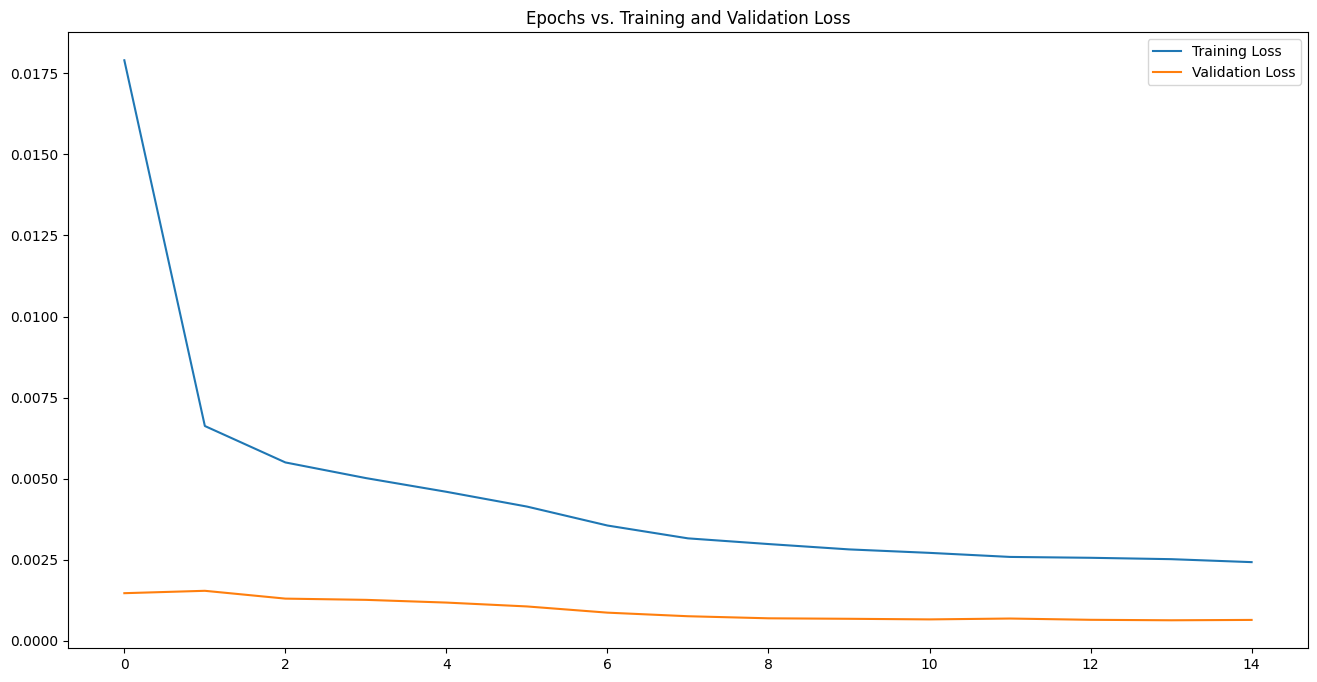

In [15]:
plot_model_loss(univariate_history)

In [16]:
# Valuta il modello
loss = model.evaluate(X_test, y_test)
print(f'Errore quadratico medio: {loss}')

# Fai previsioni per il test set
forecast = model.predict(X_test)

# Denormalizza le previsioni
uni_lstm_forecast = y_sc.inverse_transform(forecast)



150/150 [==============================] - 1s 4ms/step - loss: 5.3315e-04
Errore quadratico medio: 0.0005331471329554915
150/150 [==============================] - 1s 4ms/step


In [34]:
if univariate:
    y_test_inv = y_sc.inverse_transform(y_test.squeeze(-1))
else: 
    y_test_inv = y_sc.inverse_transform(y_test)

In [ ]:
# forflat = uni_lstm_forecast.flatten()

#### Error on rows instead of columns 

In [76]:
def evaluate_timeseries_forecast(y_test_inv, forecast):
    """
    Evaluate time series forecasts by comparing row-wise and calculate the mean error.

    Args:
        y_test_inv (array-like): Array of actual data.
        forecast (array-like): Array of forecasts.

    Returns:
        float: Mean error calculated over all rows.
    """
    # Initialize a list to store the error for each row
    errors = []

    # Loop through the rows
    for row_idx in range(y_test_inv.shape[0]):
        # Select the actual and forecasted values for the current row
        y_true_row = y_test_inv[row_idx, :]
        y_pred_row = forecast[row_idx, :]

        # Calculate the error for this row
        error_row = NMAE_error(y_true_row, y_pred_row)

        # Append the error to the list
        errors.append(error_row)

    # Calculate the mean error over all rows
    mean_error = np.mean(errors)

    return mean_error

# def evaluate_timeseries_forecast(y_test_inv, forecast):
#     """
#     Evaluate time series forecasts by comparing row-wise and calculate the mean error, RMSE, MAPE, and NMAE.

#     Args:
#         y_test_inv (array-like): Array of actual data.
#         forecast (array-like): Array of forecasts.

#     Returns:
#         tuple: Tuple containing mean error, RMSE, MAPE, and NMAE.
#     """
#     # Initialize lists to store errors for each row
#     errors = []
#     rmse_list = []
#     mape_list = []
#     nmae_list = []

#     # Loop through the rows
#     for row_idx in range(y_test_inv.shape[0]):
#         # Select the actual and forecasted values for the current row
#         y_true_row = y_test_inv[row_idx, :]
#         y_pred_row = forecast[row_idx, :]

#         # Calculate the errors for this row
#         error_row = calculate_error(y_true_row, y_pred_row)
#         rmse_row = np.sqrt(metrics.mean_squared_error(y_true_row, y_pred_row))
#         mape_row = mean_absolute_percentage_error(y_true_row, y_pred_row)
#         nmae_row = NMAE_error(y_true_row, y_pred_row)

#         # Append the errors to the lists
#         errors.append(error_row)
#         rmse_list.append(rmse_row)
#         mape_list.append(mape_row)
#         nmae_list.append(nmae_row)

#     # Calculate the mean errors
#     mean_error = np.mean(errors)
#     mean_rmse = np.mean(rmse_list)
#     mean_mape = np.mean(mape_list)
#     mean_nmae = np.mean(nmae_list)

#     return mean_error, mean_rmse, mean_mape, mean_nmae


In [77]:
def calculate_error(y_true, y_pred):
    """
    Calculate the error between a set of actual values and a set of predicted values.

    Args:
        y_true (array-like): Array of actual values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: Calculated error.
    """
    # Calculate the absolute error between the actual and predicted values for each element
    errors = np.abs(y_true - y_pred)

    # Calculate the mean error
    mean_error = np.mean(errors)

    return mean_error


In [80]:
evaluate_timeseries_forecast(y_test_inv, uni_lstm_forecast)

0.13964854683052627

In [81]:
def visualize_errors(errors):
    """
    Visualize errors calculated for each row.

    Args:
        errors (array-like): Array of errors calculated for each row.

    Returns:
        None
    """
    # Create an array of row indices
    row_indices = range(1, len(errors) + 1)

    # Plot the errors
    plt.figure(figsize=(10, 6))
    plt.bar(row_indices, errors, color='skyblue')
    plt.xlabel('Row')
    plt.ylabel('Error')
    plt.title('Errors for Each Row')
    plt.grid(True)
    plt.show()

In [82]:
errors = []

for row_idx in range(y_test_inv.shape[0]):
    y_true_row = y_test_inv[row_idx, :]
    y_pred_row = uni_lstm_forecast[row_idx, :]
    error_row = calculate_error(y_true_row, y_pred_row)
    errors.append(error_row)


In [84]:
# Ottieni il timestamp per le righe di test
test_timestamps = dataset_input.iloc[-y_test_inv.shape[0]:].index

# Converti l'indice in oggetti datetime
test_timestamps = pd.to_datetime(test_timestamps)

In [85]:
def visualize_errors_with_timestamps(errors, timestamps):
    """
    Visualizza gli errori calcolati per ogni riga con i relativi timestamp utilizzando un grafico a barre.

    Args:
        errors (array-like): Array degli errori calcolati per ogni riga.
        timestamps (array-like): Array dei timestamp corrispondenti.

    Returns:
        None
    """
    # Plot degli errori con i timestamp utilizzando un grafico a barre
    plt.figure(figsize=(12, 6))
    plt.bar(timestamps, errors, width=0.8, color='skyblue')
    plt.xlabel('Timestamp')
    plt.ylabel('Error')
    plt.title('Errors Over Time')
    plt.xticks(rotation=45)  # Ruota le etichette sull'asse x per una migliore leggibilità
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Linee orizzontali tratteggiate
    plt.tight_layout()
    plt.show()


199


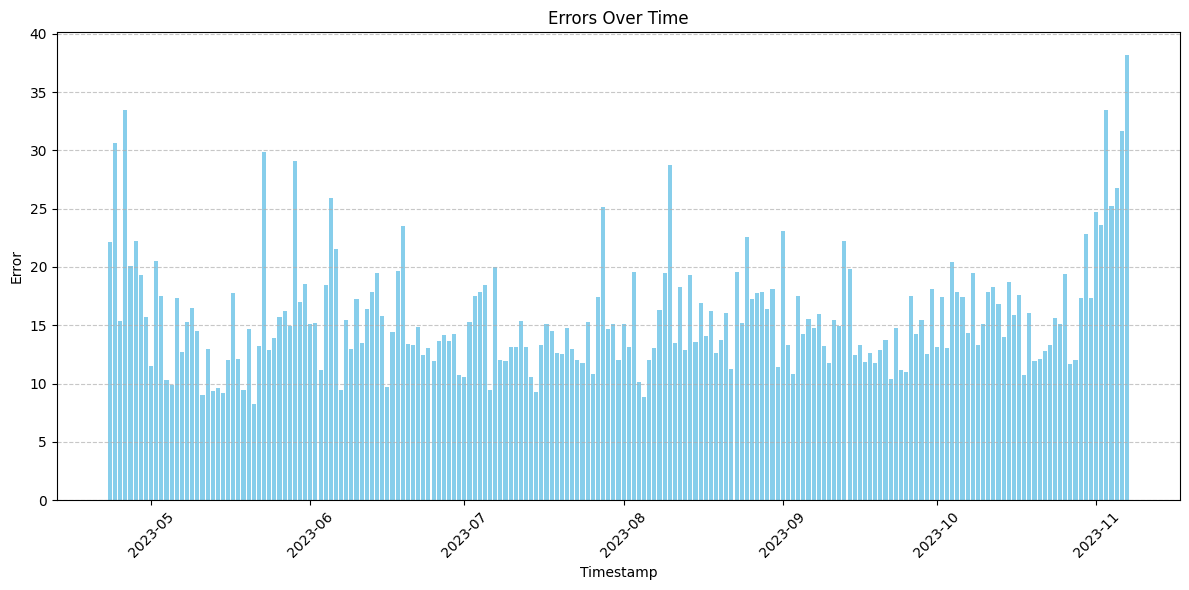

Media degli errori relativi all'orario di mezzanotte: 15.812042597558229


In [87]:
def filter_errors_at_midnight(errors, timestamps):
    '''Function used to filter only forecasts starting at 00.00'''
    midnight_errors = []
    midnight_timestamps = []
    count = 0
    for error, timestamp in zip(errors, timestamps):
        hour = timestamp.hour

        if hour == 0:
            midnight_errors.append(error)
            midnight_timestamps.append(timestamp)
            count += 1
    print(count)        
    return midnight_errors, midnight_timestamps

midnight_errors, midnight_timestamps = filter_errors_at_midnight(errors, test_timestamps)

visualize_errors_with_timestamps(midnight_errors, midnight_timestamps)

mean_midnight_error = np.mean(midnight_errors)

print("Media degli errori relativi all'orario di mezzanotte:", mean_midnight_error)

#### Errors on columns

In [89]:
uni_table = evaluate_and_plot_timeseries(y_test_inv, uni_lstm_forecast, show_plot=False)

Min NMAE: 0.116 for Column: 7.0
Min RMSE: 18.331 for Column: 7.0
Min MAPE: 17.199 for Column: 7.0
(0.116, 18.331, 17.199)


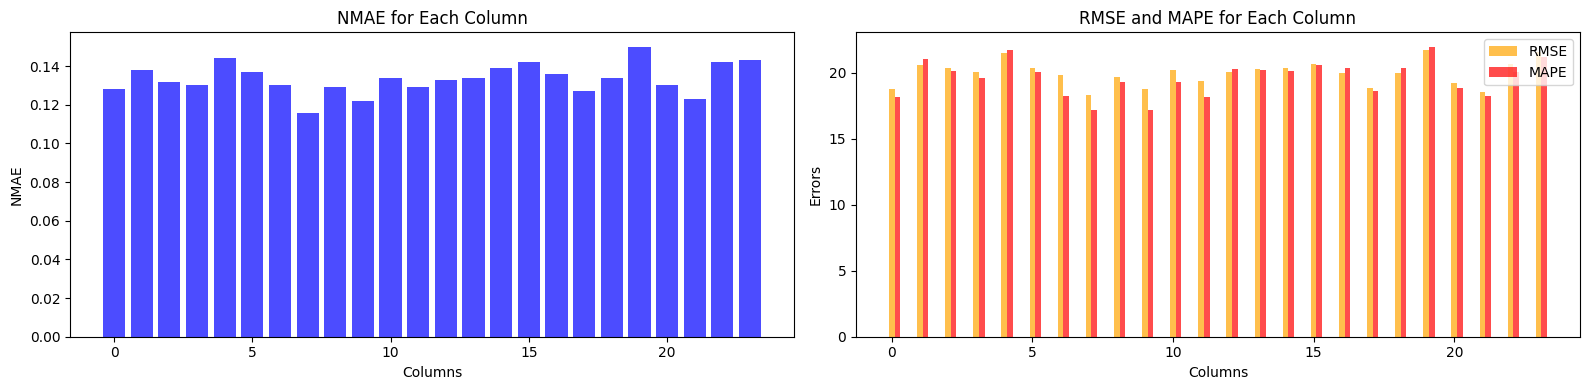

In [94]:
plot_error_metrics_barchart(uni_table)

##### Prova SHAP

In [ ]:
'''Ideas taken from https://www.kaggle.com/code/ltsmssv/shap-for-lstm-hpccv2/notebook'''

In [26]:
# !pip install shap
import shap

In [32]:
model

In [33]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_train[:100])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [36]:
help(explainer)

Help on DeepExplainer in module shap.explainers._deep object:

class DeepExplainer(shap.explainers._explainer.Explainer)
 |  DeepExplainer(model, data, session=None, learning_phase_flags=None)
 |  
 |  Meant to approximate SHAP values for deep learning models.
 |  
 |  This is an enhanced version of the DeepLIFT algorithm (Deep SHAP) where, similar to Kernel SHAP, we
 |  approximate the conditional expectations of SHAP values using a selection of background samples.
 |  Lundberg and Lee, NIPS 2017 showed that the per node attribution rules in DeepLIFT (Shrikumar,
 |  Greenside, and Kundaje, arXiv 2017) can be chosen to approximate Shapley values. By integrating
 |  over many background samples Deep estimates approximate SHAP values such that they sum
 |  up to the difference between the expected model output on the passed background samples and the
 |  current model output (f(x) - E[f(x)]).
 |  
 |  Examples
 |  --------
 |  See :ref:`Deep Explainer Examples <deep_explainer_examples>`


In [40]:
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "/home/gperri-ext/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/gperri-ext/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 370, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefix before the lookup
    File "/home/gperri-ext/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 662, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "/home/gperri-ext/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 669, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "/home/gperri-ext/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 224, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=(200, 24, 10), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


### Multivariate

In [ ]:
tf.keras.backend.clear_session()
multivariate_lstm = tf.keras.Sequential()

# multivariate_lstm.add(LSTM(200, input_shape=input_shape, return_sequences=True)) 
# multivariate_lstm.add(Dropout(0.2))

multivariate_lstm.add(LSTM(100, input_shape=input_shape)) 
multivariate_lstm.add(Dropout(0.2))


# multivariate_lstm.add(Activation(custom_activation,name = "Swish"))
# multivariate_lstm.add(Dense(100))
multivariate_lstm.add(Dense(target_size))



multivariate_lstm.summary()

In [ ]:
# Callback per il salvataggio del modello
# lstm_checkpoint = ModelCheckpoint('multivariate_lstm_df_gas.h5', monitor='val_loss', save_best_only=True)

multivariate_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
# multivariate_lstm.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(1e-8, momentum=0.9) , metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

# Vuole questa metrica altrimenti fa capricci con la stringa
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]), 1)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-5 * 10**(epoch/20))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

In [ ]:

history = multivariate_lstm.fit(X_train, y_train, epochs=50, verbose=1,
                                validation_split=0.2, batch_size=64,
                                callbacks=[early_stopping, lr_schedule])

plot_model_rmse_and_loss(history)


In [ ]:
# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)


In [ ]:
lstm_table = evaluate_and_plot_timeseries(y_test_inv, lstm_forecast, show_plot=True)

In [ ]:
plot_error_metrics_barchart(lstm_table)


### Hyperparameters search

In [ ]:
# Define the model function
def build_model(hp):
  model = tf.keras.Sequential()
  # Choose the number of LSTM layers between 1 and 3
  for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
    # Choose the number of LSTM units between 50 and 200
    # Check the value of num_layers to set return_sequences
    if hp.get('num_layers') == 1:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    else:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    # Choose the dropout between 0 and 0.5
    model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0, max_value=0.5, step=0.1)))
  # Add the output layer with one neuron for each hour to predict
  model.add(Dense(y_train.shape[1]))
  # Compile the model using adam as optimizer and mean_squared_error as loss function
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

tuner = kt.BayesianOptimization(build_model, objective='val_loss', max_trials=10, 
                                num_initial_points=2, beta=2.6, project_name='LSTM_tuning_multivariate')

tuner.search(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks = [early_stopping], verbose=2)
best_model = tuner.get_best_models()[0]

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# Print the values of each hyperparameter
print("Best number of layers:", best_hps.get("num_layers"))
print("Best number of units for layer 0:", best_hps.get("units_0"))
print("Best dropout for layer 0:", best_hps.get("dropout_0"))
# Repeat for the other layers if num_layers > 1


In [ ]:
tuned_forecast = best_model.predict(X_test)

# Denormalizza le previsioni
tuned_uni_lstm_forecast = y_sc.inverse_transform(tuned_forecast)

In [ ]:
y_test_inv_uni = y_sc.inverse_transform(y_test.squeeze(-1))

In [ ]:
null_indices = np.where(y_test_inv_uni[:,0] == 0)

In [ ]:
y_test_inv_uni[null_indices, 0] = 5

In [ ]:
# y_test_inv_uni = scaler.inverse_transform(y_test)
uni_table = evaluate_and_plot_timeseries(y_test_inv_uni, tuned_uni_lstm_forecast, show_plot=True)

In [ ]:
plot_error_metrics_barchart(uni_table)